In [131]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano
from theano import tensor as T
import arviz as az

## Define a theano function that encodes the guessing probabilites

In [189]:
def normalize(array, axis):
    return array / array.sum(axis=axis, keepdims=True)

def calculate_L1(language, α, costs):
    """
    Parameters
    ----------
    language: array
        Array with shape (signals, states)
        
    Return
    ------
    array
        Array with shape (signals, states)
        With the p of each state given each signal
        for pragmatic listener
        (normalized rows)
    """
    
    # Assuming a uniform prior for the literal listener, 
    # L0 is just a normalized version (by column) of the language
    L0 = normalize(language, axis=1)
    # S1 is a softexp of the utility, with α temperature parameter
    # The line below is equivalent to:
#     util = np.log(L0) - costs.reshape(-1,1)
#     S1 = normalize(np.exp(α * util), axis=0)
    # Except that it avoids log and then exp of 0, 
    # which breaks the calculation of the gradient in theano
    S1 = normalize( L0**α / T.exp(costs.reshape(-1,1)*α), axis=0)
    return normalize(S1, axis=1)

In [159]:
theano.config.compute_test_value = 'ignore'

## Simulate fake data and then recover the $\alpha$ parameter

In [180]:
language = np.array([
    [1, 1, 0],
    [1, 1, 1]
])
costs = np.array([0,0])
α = T.dscalar()

L1 = calculate_L1(language, α, costs)
f = theano.function([α], L1)

<ipython-input-178-d1257fae04de>:25: RuntimeWarning: divide by zero encountered in log
  util = np.log(L0) - costs.reshape(-1,1)


In [181]:
L1_real = f(0.87)

In [182]:
L1_real

array([[0.5       , 0.5       , 0.        ],
       [0.22609181, 0.22609181, 0.54781638]])

Simulate some data given a language and a true $\alpha$.

In [191]:
signals = np.repeat([0,1], 500)
# This line taken from 
# https://stackoverflow.com/questions/47722005/vectorizing-numpy-random-choice-for-given-2d-array-of-probabilities-along-an-a
guesses = (L1_real[signals].cumsum(1) > np.random.rand(L1_real[signals].shape[0])[:,None]).argmax(1)

In [188]:
with pm.Model() as model:
    # Sample α
    α = pm.HalfNormal('α', 3)
    # Calculate the array containing
    # the probability of each state given each
    # signal according to L1
    L1 = calculate_L1(language, α, costs)
    # Feed the observed data to PyMC3
    pm.Categorical(
        'guesses', 
        p=L1[signals], 
        observed=guesses,
        shape=len(guesses),
    )
    # Sample from the posterior
    trace = pm.sample(
        cores=1,
        return_inferencedata=True,
        target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>]], dtype=object)

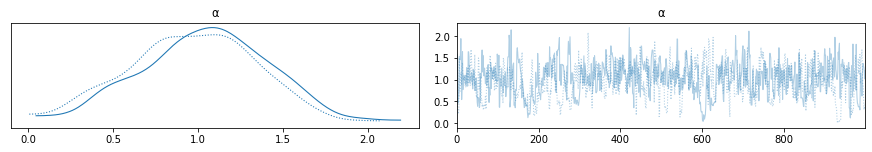

In [190]:
# Plot the posterior
# It's pretty accurate!
az.plot_trace(trace)